In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as tr
import skimage.color
import dask.array as da
from glob import glob
from unet import UNet
import dask_imread

In [176]:
def read_imgs(path, size):
    imgs = []
    paths = glob(path)
    for p in paths:
        img = io.imread(p)
        img = tr.resize(img, size)
        imgs.append(img)
    return np.array(imgs)

x = read_imgs('C:/Users/wohlfart/Desktop/testset2/neu2/images/*.png', (224,244,3))
y = read_imgs('C:/Users/wohlfart/Desktop/testset2/neu/masks/*.png', (224,244,1))
print (y[1].shape)

c:\users\wohlfart\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\wohlfart\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(224, 244, 1)


In [184]:
path1 = 'C:/Users/wohlfart/Desktop/testset2/neu/'
path2 = 'C:/Users/wohlfart/Desktop/testset2/neu2/'
image_generator = ImageDataGenerator().flow_from_directory(path2, target_size=(224,224), batch_size=5, class_mode=None, shuffle=False)
mask_generator =  ImageDataGenerator().flow_from_directory(path1, target_size=(224,224), color_mode ='grayscale', batch_size=5, class_mode=None, shuffle=False)
train_generator = zip(image_generator, mask_generator)

print (image_generator[0].shape)
print (mask_generator[0].shape)


Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.
(5, 224, 224, 3)
(5, 224, 224, 1)


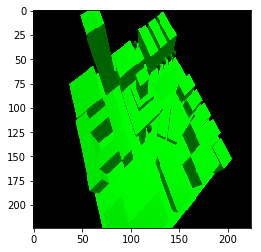

c:\users\wohlfart\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\wohlfart\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


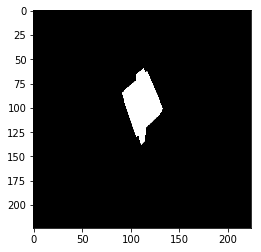

In [220]:
i = 3
plt.imshow(image_generator[0][i].astype(np.uint8))
plt.show()
gray = np.asarray(mask_generator[0][i].astype(np.uint8))
gray = tr.resize(gray,(224,224,3))
gray = skimage.color.rgb2gray(gray)
plt.imshow(gray, cmap='gray')
plt.show()

In [208]:
def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1. - intersection)

def iou_loss(y_true, y_pred):
    return  -iou(y_true, y_pred)

In [186]:
model = UNet((224,224,3), 1, 16, 4, 2.0)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_522 (Conv2D)             (None, 224, 224, 16) 448         input_31[0][0]                   
__________________________________________________________________________________________________
conv2d_523 (Conv2D)             (None, 224, 224, 16) 2320        conv2d_522[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_93 (MaxPooling2D) (None, 112, 112, 16) 0           conv2d_523[0][0]                 
__________________________________________________________________________________________________
conv2d_524

In [187]:
model.compile(optimizer=Adam(lr=0.001), loss=iou_loss)

In [188]:
model.fit_generator(train_generator, samples_per_epoch=3, epochs=2, verbose=2)

c:\users\wohlfart\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<zip objec..., epochs=2, verbose=2, steps_per_epoch=3)`
  """Entry point for launching an IPython kernel.


Epoch 1/2
 - 5s - loss: -1.6854e+00
Epoch 2/2
 - 0s - loss: -1.1350e+01


In [134]:
model.save('modelsave5.h5')